In [194]:
import pandas as pd
import plotly.express as px
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

In [168]:
data = pd.read_excel('data.xlsx')
data["DATE"] = pd.to_datetime(data["DATE"])
data.set_index('DATE', inplace=True)
indexes = list(data.columns)

In [169]:
data_base100 = data.copy()
for col in indexes:
    data_base100[col] = (data_base100[col] / data_base100[col].iloc[0]) * 100
fig = px.line(data_base100, x=data.index, y=indexes,
              title="Évolution des indices en base 100",
              labels={"value": "Prix des indices", "variable": "Indices", "Date": "Date"})

# Afficher le graphique
fig.show()

### Calcul des fenetres glissantes

In [173]:
data_returns = data.copy()
for col in indexes:
    data_returns[col] = (data_returns[col] / data_returns[col].shift(1))-1

In [189]:
def compute_cvar(window, confidence_level = 0.95):
    var = np.percentile(window, (1 - confidence_level) * 100)  # Calcul de la VaR
    cvar = np.mean(window[window <= min(var,0)])  # Calcul empirique de la CVaR
    return cvar  

In [190]:
returns_5yr = pd.DataFrame(index=data_returns.index)
vol_5yr = pd.DataFrame(index=data_returns.index)
window_size = 60 # Fenetre de 50 ans donc 60 observations
confidence_level = 0.95 # Interval de confiance de la CVaR
for col in indexes:
    returns_5yr[col] = (
        (data_returns[col] + 1)
        .rolling(window=window_size)
        .apply(np.prod, raw=True) ** (12 / window_size) - 1
    ) * 100  # En pourcentage
    # Volatilité annualisée sur 5 ans (fenêtre glissante)
    vol_5yr[col] = data_returns[col].rolling(window=window_size
                    ).std() * np.sqrt(12) * 100
returns_5yr.dropna(inplace=True)
vol_5yr.dropna(inplace=True)


In [191]:
fig = px.line(returns_5yr.dropna(), x=returns_5yr.dropna().index, y=indexes,
              title="Rendements annualisé sur 5 ans des indices boursiers",
              labels={"value": "Rendements (%)", "variable": "Indices", "Date": "Date"})

# Afficher le graphique
fig.show()

In [192]:
fig = px.line(vol_5yr.dropna(), x=vol_5yr.dropna().index, y=indexes,
              title="Volatilité annualisé sur 5 ans des indices boursiers",
              labels={"value": "Volatilité (%)", "variable": "Indices", "Date": "Date"})
fig.show()

In [ ]:
# CVaR = pd.DataFrame(index=indexes, columns=["CVaR"])
# for index in indexes:
#     annualized_returns = np.array(returns_5yr[index].dropna())
#     cvar = compute_var_cvar(annualized_returns, confidence_level)
#     CVaR.loc[index, "CVaR"] = cvar

In [ ]:
# final_df = pd.DataFrame({
#     "Mean Returns": returns_5yr.mean(),
#     "Annualized Volatility": vol_5yr.mean(),
#     "CVaR": CVaR["CVaR"]
# })

In [188]:
def ratio_cvar(mean_return, cvar):
    if cvar<0:
        return mean_return/cvar
    else:
        return mean_return*cvar

### Calcul des rendements et Vol moyennes

In [196]:
# Nombre de portefeuilles à simuler
num_portfolios = 10000

# Initialisation des résultats
results = np.zeros((2, num_portfolios))

# Simulation des portefeuilles
for i in tqdm(range(num_portfolios)):
    # Générer des poids aléatoires pour chaque actif
    weights = np.random.random(len(indexes))
    weights /= np.sum(weights)  # Normalisation des poids pour qu'ils somme à 1
    
    # Calcul du rendement attendu du portefeuille
    portfolio_returns = np.dot(returns_5yr, weights)
    mean_return = np.mean(portfolio_returns)
    cvar = compute_cvar(portfolio_returns)
    # Stocker les résultats
    results[0, i] = mean_return
    results[1, i] = cvar
    #results[2, i] = ratio_cvar(mean_return, cvar)

# Identifier le portefeuille avec le meilleur ratio de Sharpe
# max_ratio_idx = np.argmax(results[2])
# max_sharpe_return = results[0, max_sharpe_idx]
# max_sharpe_volatility = results[1, max_sharpe_idx]

# # Identifier le portefeuille avec la volatilité minimale
# min_volatility_idx = np.argmin(results[1])
# min_volatility_return = results[0, min_volatility_idx]
# min_volatility_volatility = results[1, min_volatility_idx]

# # Tracer la frontière efficiente
# plt.figure(figsize=(10, 6))
# plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='YlGnBu', marker='o', alpha=0.5)
# plt.title('Frontière Efficiente de Markowitz')
# plt.xlabel('Volatilité')
# plt.ylabel('Rendement attendu')
# plt.colorbar(label='Ratio de Sharpe')

# # Marquer les portefeuilles optimaux
# plt.scatter(max_sharpe_volatility, max_sharpe_return, color='r', marker='*', s=200, label="Portefeuille Max Sharpe")
# plt.scatter(min_volatility_volatility, min_volatility_return, color='g', marker='*', s=200, label="Portefeuille Min Volatility")

# plt.legend(loc='upper left')
# plt.show()

100%|██████████| 100000/100000 [00:48<00:00, 2068.84it/s]


C:\Users\bapdu\AppData\Local\Temp\ipykernel_19444\206846634.py:3: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

C:\Users\bapdu\AppData\Local\Temp\ipykernel_19444\206846634.py:8: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



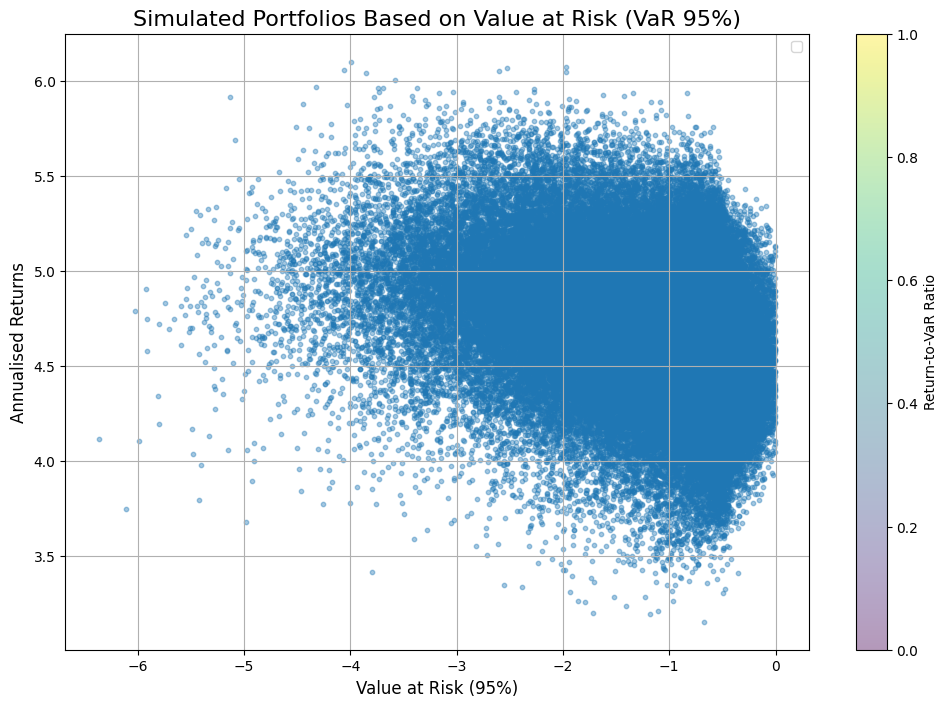

In [199]:
plt.figure(figsize=(12, 8))
# Nuage de points pour les portefeuilles simulés
plt.scatter(results[1, :], results[0, :], cmap='YlGnBu', marker='o', s=10, alpha=0.4)
plt.colorbar(label='Return-to-VaR Ratio')
plt.title('Simulated Portfolios Based on Value at Risk (VaR 95%)', fontsize=16)
plt.xlabel('Value at Risk (95%)', fontsize=12)
plt.ylabel('Annualised Returns', fontsize=12)
plt.legend(labelspacing=0.8)
plt.grid(True)
plt.show()

In [120]:
num_portfolios = 10000
import plotly.graph_objects as go
# Initialisation des résultats
results = np.zeros((3, num_portfolios))

# Simulation des portefeuilles
for i in range(num_portfolios):
    # Générer des poids aléatoires pour chaque actif
    weights = np.random.random(len(indexes))
    weights /= np.sum(weights)  # Normalisation des poids pour qu'ils somme à 1
    
    # Calcul du rendement attendu du portefeuille
    portfolio_return = np.sum(weights * mean_returns)
    
    # Calcul de la volatilité (écart-type) du portefeuille à partir de la matrice de covariance
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # Stocker les résultats
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = (portfolio_return - 0.01) / portfolio_volatility  # Ratio de Sharpe (taux sans risque de 1%)

# Identifier le portefeuille avec le meilleur ratio de Sharpe
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]

# Identifier le portefeuille avec la volatilité minimale
min_volatility_idx = np.argmin(results[1])
min_volatility_return = results[0, min_volatility_idx]
min_volatility_volatility = results[1, min_volatility_idx]

# Créer la figure avec Plotly
fig = go.Figure()

# Ajouter les portefeuilles simulés
fig.add_trace(go.Scatter(
    x=results[1, :],
    y=results[0, :],
    mode='markers',
    marker=dict(color=results[2, :], colorscale='YlGnBu', size=5, opacity=0.5),
    name='Portefeuilles simulés',
    hovertemplate='Rendement: %{y:.2f}<br>Volatilité: %{x:.2f}<br>Ratio de Sharpe: %{marker.color:.2f}<extra></extra>'
))

# Ajouter le portefeuille avec le meilleur ratio de Sharpe
fig.add_trace(go.Scatter(
    x=[max_sharpe_volatility],
    y=[max_sharpe_return],
    mode='markers',
    marker=dict(color='red', size=10, symbol='star'),
    name='Portefeuille Max Sharpe',
    hovertemplate=f'Portefeuille Max Sharpe<br>Rendement: {max_sharpe_return:.2f}<br>Volatilité: {max_sharpe_volatility:.2f}<extra></extra>'
))

# Ajouter le portefeuille avec la volatilité minimale
fig.add_trace(go.Scatter(
    x=[min_volatility_volatility],
    y=[min_volatility_return],
    mode='markers',
    marker=dict(color='green', size=10, symbol='star'),
    name='Portefeuille Min Volatility',
    hovertemplate=f'Portefeuille Min Volatility<br>Rendement: {min_volatility_return:.2f}<br>Volatilité: {min_volatility_volatility:.2f}<extra></extra>'
))

# Ajouter les informations sur le graphique
fig.update_layout(
    title='Frontière Efficiente de Markowitz',
    xaxis_title='Volatilité',
    yaxis_title='Rendement attendu',
    coloraxis_colorbar=dict(
        title="Ratio de Sharpe",
        tickvals=[-1, 0, 1],
        ticktext=["-1", "0", "1"]
    ),
    template='plotly_dark',
    hovermode="closest"
)

# Afficher le graphique
fig.show()